<a href="https://colab.research.google.com/github/popsi-techy/sms_text_classifier/blob/main/sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A neural network is a machine learning model inspired by the human brain. It consists of interconnected artificial neurons organized into layers. Neural networks are used for tasks like pattern recognition and decision making. They learn from data by adjusting the strength of connections (weights) between neurons. Deep learning involves neural networks with many layers, enabling them to learn complex patterns and representations from large datasets.

In this project, I created a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

I created a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

I used the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv


In [ ]:
#Prepare data
#Train data frame
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()


In [ ]:
#Test data frame
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

In [ ]:
#prepare labels for training
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()

In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [ ]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec


In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#create a TextVectorization layer for our model
vec = tf.keras.layers.TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))


In [ ]:
# Let's show the vocabulary that our vectorizer has learned
vocab = np.array(vec.get_vocabulary())
vocab[:20]


In [ ]:
#create the model
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
# train model against our data sets
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
#plot the accuracy and loss matrix
# create a helper function to plot
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


(0.0, 0.7038043610751629)

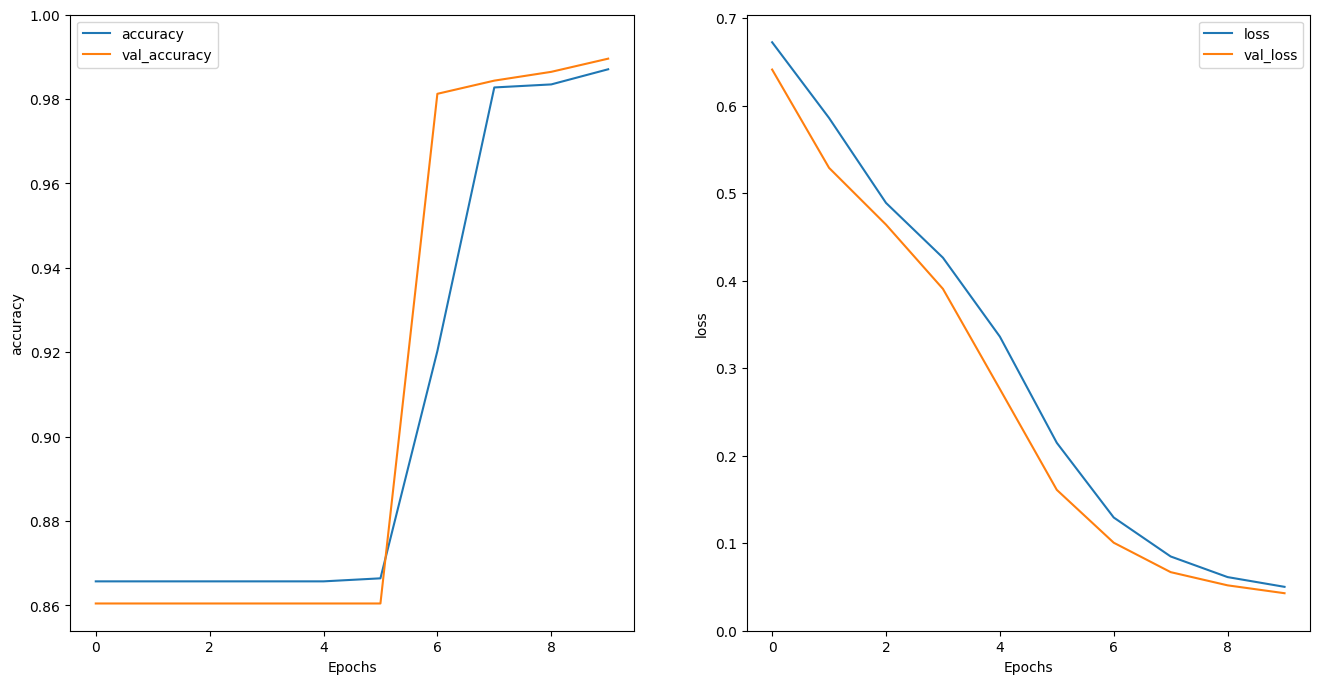

In [ ]:
#plot the graphs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 196ms/step
[[-5.4333706]]
1/1 [==============================] - 0s 200ms/step
[[0.5555707]]
1/1 [==============================] - 0s 207ms/step
[[-11.169899]]
1/1 [==============================] - 0s 207ms/step
[[1.454182]]
1/1 [==============================] - 0s 209ms/step
[[2.4400191]]
1/1 [==============================] - 0s 203ms/step
[[-8.555567]]
1/1 [==============================] - 0s 196ms/step
[[-9.384332]]
You passed the challenge. Great job!
